In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from transformers import BertTokenizer, BertModel
from bs4 import BeautifulSoup
import torch
import sklearn

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip


In [2]:
# unzip the files
import zipfile

datasets = ("sample_submission.csv", "test.csv", "test_labels.csv", "train.csv")

for d in datasets:
    with zipfile.ZipFile("../input/jigsaw-toxic-comment-classification-challenge/"+d+".zip","r") as z:
        z.extractall(".")

In [5]:
test = pd.read_csv("/kaggle/working/test.csv")
train = pd.read_csv("/kaggle/working/train.csv")

In [6]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

## Some EDA

In [16]:
train['comment_text'].head()

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: comment_text, dtype: object

In [4]:
# check for any missing values
train.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [9]:
# don't need this column
train = train.drop(['id'], axis=1)

In [10]:
train

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [15]:
# check balancing of the labels
for i in train[labels].columns :
    print(f"Percent of {i}: {round(100*train[i].mean(),2)}")

Percent of toxic: 9.58
Percent of severe_toxic: 1.0
Percent of obscene: 5.29
Percent of threat: 0.3
Percent of insult: 4.94
Percent of identity_hate: 0.88


### Pre-processing & data cleaning

In [17]:
import re

def pre_process(text):
    text = BeautifulSoup(text).get_text()
    # fetch alphabetic characters

    text = re.sub("[^a-zA-Z]", " ", text)
    # convert text to lower case
    text = text.lower()
    # split text into tokens to remove whitespaces
    tokens = text.split()
    return " ".join(tokens)

In [18]:
train['comment_text'] = train['comment_text'].map(pre_process)

/tmp/ipykernel_28/772656908.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text).get_text()
/tmp/ipykernel_28/772656908.py:4: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  text = BeautifulSoup(text).get_text()


### stop words

In [19]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
train['comment_text'] = train['comment_text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

### stemming

In [20]:
from nltk.stem.snowball import SnowballStemmer

#stemming
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

train['comment_text'] = train['comment_text'].apply(stemming)

### investigate text lenghts

In [21]:
train['word_count'] = train['comment_text'].apply(lambda x: len(str(x).split(" ")))

array([[<Axes: title={'center': 'word_count'}>]], dtype=object)

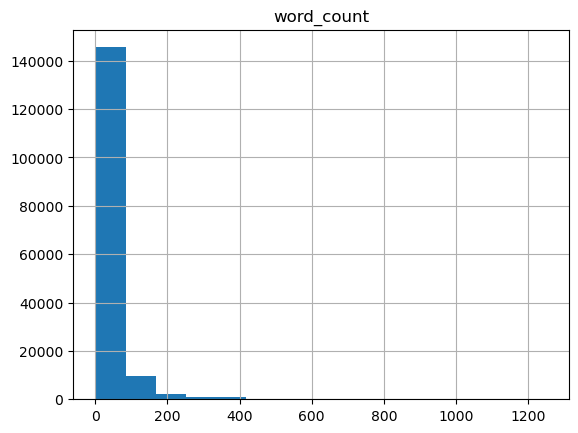

In [22]:
train.hist(column='word_count', bins = 15)
# no text is longer than 512, ok for Bert model

## Split data into training, validation and test datasets

In [23]:
y = train[labels]
x = train[['comment_text']]

### sample 10,000 data to demo and get the model to run

In [24]:
import random
from random import sample
random.seed(4)
i = sample(range(x.shape[0]), 10000)

In [25]:
X_new = x.iloc[i]
y_new = y.iloc[i]

## stratified sampling to handle imbalanced data for multilabel classification
- useful [reference](https://github.com/scikit-multilearn/scikit-multilearn/issues/194) to get data into right format

In [26]:
from skmultilearn.model_selection import iterative_train_test_split
x_temp, y_temp, x_test, y_test = iterative_train_test_split(X_new.values, y_new.values, test_size = 0.1)

# split into training and validation
x_train, y_train, x_val, y_val = iterative_train_test_split(x_temp, y_temp, test_size = 0.2)

In [27]:
y_train = y_train.astype(float)
y_val = y_val.astype(float)
y_test = y_test.astype(float)

## Format data for BERT model

In [30]:
# Set up device for GPU usage for neural network training
from torch import cuda

device = 'cuda' if cuda.is_available() else 'cpu'

In [28]:
from datasets.dataset_dict import DatasetDict
from datasets import Dataset

dataset = {'train':Dataset.from_dict({'comment_text':x_train, 'labels':y_train}),
           'val':Dataset.from_dict({'comment_text':x_val, 'labels':y_val}),
           'test':Dataset.from_dict({'comment_text':x_test, 'labels':y_test}),
          }

dataset = DatasetDict(dataset)

In [29]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}

### tokenize for Transformer

In [31]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def format_data(data):

    text = data["comment_text"]
    # encode them
    encoding = tokenizer(text, padding="max_length", truncation=True, max_length=128,is_split_into_words=True)
    encoding["labels"] = data["labels"]
    
    return encoding

In [32]:
encoded_dataset = dataset.map(format_data, batched =True)

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

### inspect the encoded data

In [36]:
example = encoded_dataset['train'][0]
print(example.keys())

dict_keys(['comment_text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'])


In [37]:
tokenizer.decode(example['input_ids'])

'[CLS] know us trail dead consid steampunk thing goe faint beatl eleanor rigbi [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [40]:
example['labels']

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [41]:
[id2label[idx] for idx, label in enumerate(example['labels']) if label == 1]

[]

#### set the format of our training, validation and test datasets into PyTorch datasets

In [42]:
encoded_dataset.set_format("torch")

In [43]:
encoded_dataset['train']['input_ids'][0]

tensor([  101,  2113,  2149,  4446,  2757,  9530,  5332,  2094,  5492, 14289,
         8950,  2518,  2175,  2063,  8143,  3786,  2140, 10508, 19838,  5638,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

### Model Definition

usingi weights from the pre-trained base, bert-base-uncase. 

can specify multi-label problem using:
- `problem_type = "multi_label_classification"`
- `num_labels = len(labels)`

In [50]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", 
                                                           problem_type="multi_label_classification", 
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

# Train model

In [51]:
# model config

BATCH_SIZE = 32
METRIC_NAME = 'f1'
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 5
WEIGHT_DECAY = 0.01

In [52]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    f"bert-finetuned-sem_eval-english",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_TRAIN_EPOCHS,
    weight_decay= WEIGHT_DECAY,
    load_best_model_at_end=True,
    metric_for_best_model=METRIC_NAME,
)

In [53]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch
    
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    # probabilities, output from sigmoid function
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return metrics as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

In [54]:
encoded_dataset['train']['labels'][0].unsqueeze(0)

tensor([[0., 0., 0., 0., 0., 0.]])

In [55]:
encoded_dataset['train']['input_ids'][0].type()

'torch.LongTensor'

In [56]:
# forward pass
outputs = model(input_ids=encoded_dataset['train']['input_ids'][0].unsqueeze(0), labels=encoded_dataset['train']['labels'][0].unsqueeze(0))
outputs

SequenceClassifierOutput(loss=tensor(0.5242, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), logits=tensor([[-0.2965, -0.2172,  0.0960, -0.8095, -0.6716, -0.4949]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [57]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["val"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [58]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,No log,0.091143,0.421260,0.636348,0.902778
2,No log,0.064466,0.714667,0.838340,0.912778
3,No log,0.058087,0.722955,0.845916,0.914444
4,No log,0.058059,0.734848,0.866839,0.911667
5,0.087200,0.056349,0.736292,0.856147,0.915556


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

TrainOutput(global_step=565, training_loss=0.0823273278970634, metrics={'train_runtime': 536.1664, 'train_samples_per_second': 67.143, 'train_steps_per_second': 1.054, 'total_flos': 2368084543488000.0, 'train_loss': 0.0823273278970634, 'epoch': 5.0})

# Evaluate on test dataset

In [59]:
trainer.evaluate(eval_dataset=encoded_dataset["test"])

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.06656398624181747,
 'eval_f1': 0.6698564593301435,
 'eval_roc_auc': 0.8131645171437558,
 'eval_accuracy': 0.905,
 'eval_runtime': 4.7096,
 'eval_samples_per_second': 212.333,
 'eval_steps_per_second': 3.397,
 'epoch': 5.0}